In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import RocCurveDisplay

%matplotlib inline

In [2]:
X = pd.read_csv('data/training_set_features.csv')
y = pd.read_csv('data/training_set_labels.csv')

In [3]:
data = pd.concat([X,y], axis = 1)
data = data.drop('respondent_id', axis = 1)

In [4]:
data.isna().sum()/len(data)

h1n1_concern                   0.003445
h1n1_knowledge                 0.004343
behavioral_antiviral_meds      0.002658
behavioral_avoidance           0.007788
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001573
behavioral_large_gatherings    0.003258
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
health_insurance               0.459580
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
opinion_h1n1_sick_from_vacc    0.014790
opinion_seas_vacc_effective    0.017299
opinion_seas_risk              0.019246
opinion_seas_sick_from_vacc    0.020107
age_group                      0.000000
education                      0.052683
race                           0.000000
sex                            0.000000


In [5]:
data.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [6]:
# DROP: employment_industry, employment_occupation, hhs_geo_region, census_msa
# Note: lots of missing values for 'health_insurance', but may be useful for prediction.
# use 'missing' for health_insurance AND income_poverty

In [7]:
drop_cols = ['respondent_id','employment_industry', 'employment_occupation', 'hhs_geo_region', 'census_msa'] # columns we will drop
object_cols = ['behavioral_antiviral_meds','behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
               'behavioral_large_gatherings', 'behavioral_outside_home','behavioral_touch_face', 'doctor_recc_h1n1', 
               'doctor_recc_seasonal','chronic_med_condition', 'child_under_6_months', 'health_worker','health_insurance',
               'race', 'sex','marital_status','rent_or_own', 'employment_status'] # columns we will one hot encode
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc',
            'opinion_seas_vacc_effective','opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 
            'household_children'] # cols to be treated as numerical data
num_cols_obj = ['age_group','education', 'income_poverty',] # cols to treat as numerical data (first need to be converted to integers)

In [8]:
age_map = {'18 - 34 Years': 0,'35 - 44 Years': 1,'45 - 54 Years': 2,'55 - 64 Years': 3, '65+ Years': 4}
education_map = {'< 12 Years': 0, '12 Years': 1, 'Some College': 2,'College Graduate': 3}
income_map = {'Below Poverty': 0, '<= $75,000, Above Poverty': 1, '> $75,000': 2}

In [9]:
def order_encode(df, cols, maps):
    for i,col in enumerate(cols):
        df[col] = df[col].replace(maps[i])
    return df

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [11]:
def preprocess(df):
    '''Drops irrelevant columns and encodes ordinal data.'''
    df = df.drop(drop_cols, axis = 1)
    df = order_encode(df, num_cols_obj, [age_map, education_map, income_map])
    df['health_insurance'] = df['health_insurance'].fillna('missing')
    df['health_insurance'] = df['health_insurance'].replace({0:'No', 1:'Yes'})
    return df

In [12]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [13]:
obj_transformer = Pipeline([('cat_imputer', SimpleImputer(strategy = 'most_frequent')), 
                            ('cat_encoder', OneHotEncoder(drop = 'first', sparse = False))])
num_transformer = Pipeline([('num_scaler', StandardScaler()),
                            ('num_imputer', KNNImputer())])

In [14]:
preprocessing_transformer = ColumnTransformer([('cat_transformer', obj_transformer, object_cols),
                                    ('num_transformer', num_transformer, num_cols+num_cols_obj)])

In [15]:
X_train = preprocessing_transformer.fit_transform(X_train)
X_test = preprocessing_transformer.fit_transform(X_test)

## Model Validation

In [16]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
y_train = y_train.drop('respondent_id', axis = 1)
y_test = y_test.drop('respondent_id', axis = 1)

In [18]:
#lin_model = MultiOutputClassifier(LogisticRegression()) 
#lin_model.fit(X_train,y_train)

In [19]:
#svc_model = MultiOutputClassifier(SVC(probability = True))
#svc_model.fit(X_train,y_train)

In [20]:
#knn_model = KNeighborsClassifier(n_neighbors = 50)
#knn_model.fit(X_train,y_train)

In [21]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train,y_train)

RandomForestClassifier()

In [22]:
preds = random_forest.predict_proba(X_test)

In [23]:
h1n1_preds = preds[0][:,1]
seasonal_preds = preds[1][:,1]

y_h1n1 = np.array(y_test.iloc[:,0])
y_seasonal = np.array(y_test.iloc[:,1])

In [24]:
h1n1_fpr, h1n1_tpr, h1n1_thresholds = roc_curve(y_h1n1, h1n1_preds)
baseline_h1n1_auc = auc(h1n1_fpr, h1n1_tpr)
sea_fpr, sea_tpr, sea_thresholds = roc_curve(y_seasonal, seasonal_preds)
baseline_sea_auc = auc(sea_fpr, sea_tpr)

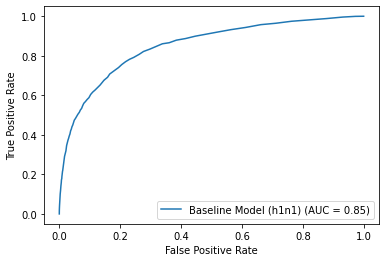

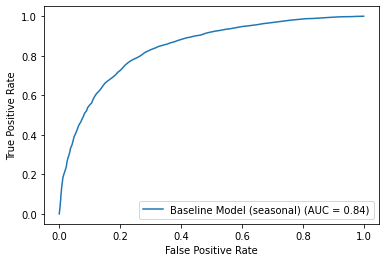

In [28]:
display = RocCurveDisplay(fpr = h1n1_fpr, tpr = h1n1_tpr, roc_auc = baseline_h1n1_auc,estimator_name = 'Baseline Model (h1n1)')
display.plot()
plt.show()


display = RocCurveDisplay(fpr = sea_fpr, tpr = sea_tpr, roc_auc = baseline_sea_auc,estimator_name = 'Baseline Model (seasonal)')
display.plot()
plt.show()